In [1]:
# Example of taking the output of our tally form to bootstrap a model card
import sys
import json
from IPython import display

# parent directory to work with dev
sys.path.append("..")
import model_card_toolkit as mctlib
from model_card_toolkit import model_card_pb2, ModelCard
from model_card_toolkit.utils.tally_form import tally_form_to_mc

## Prep test dataset

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import category_encoders as ce

from ModelTests.FEAT import SubgroupDifference
from ModelTests.FEAT.SubgroupMetricThreshold import SubgroupMetricThreshold
from ModelTests.FEAT.Permutation import Permutation
from ModelTests.FEAT.SHAPFeatureImportance import SHAPFeatureImportance
from ModelTests.FEAT.FeatureImportance import FeatureImportance
from ModelTests.FEAT.DataShift import DataShift

In [3]:
# Credit dataset
df = pd.read_csv("../data/credit_reject.csv")
x = df.drop("reject", axis=1)
y = df["reject"]

# # Credit Card Fraud Dataset
# df = pd.read_csv("../data/fraud.csv")
# x = df.drop("is_fraud", axis=1)
# y = df["is_fraud"]


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.8, random_state=32
)
estimator = RandomForestClassifier(n_estimators=10, max_features="sqrt")
# estimator = LogisticRegression()

# Apply one hot encoding to categorical columns (auto-detect object columns)
ens = ce.OneHotEncoder(use_cat_names=True)
x_train = ens.fit_transform(x_train)
x_test = ens.transform(x_test)

estimator.fit(x_train, y_train)

output = x_test.copy()
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]
# print(confusion_matrix(y_test, y_pred))

output = ens.inverse_transform(output)
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


df_importance = pd.DataFrame(
    {"features": x_test.columns, "value": estimator.feature_importances_}
)
#df_importance = df_importance.sort_values(df_importance.columns[1], ascending=False)
train = ens.inverse_transform(x_train)
test = ens.inverse_transform(x_test)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


## Run some FEAT Tests on it

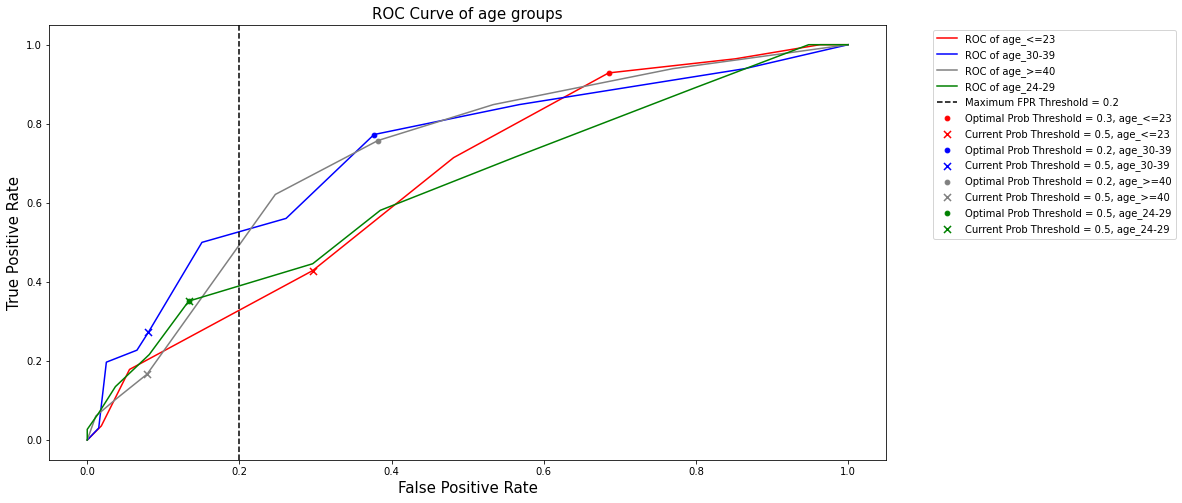

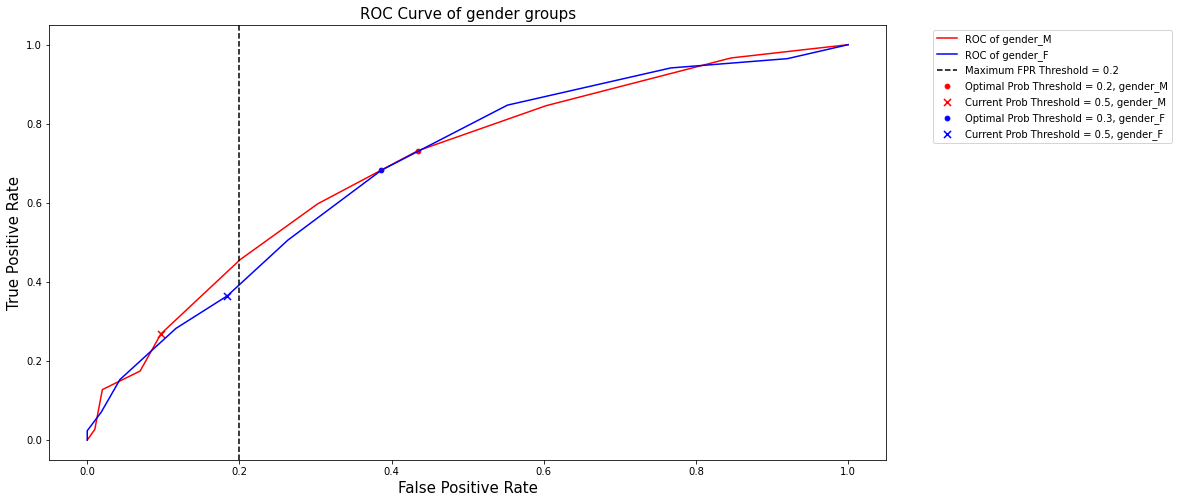

In [4]:
smt_test = SubgroupMetricThreshold(
    #test_name="subgroup metric threshold",
    #test_desc="",
    attr="age",
    metric="fpr",
    threshold=0.2,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test.run(df_test_with_output=output)
smt_test.plot()

smt_test2 = SubgroupMetricThreshold(
    #test_name="subgroup metric threshold",
    #test_desc="",
    attr="gender",
    metric="fpr",
    threshold=0.2,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test2.run(df_test_with_output=output)
smt_test2.plot()

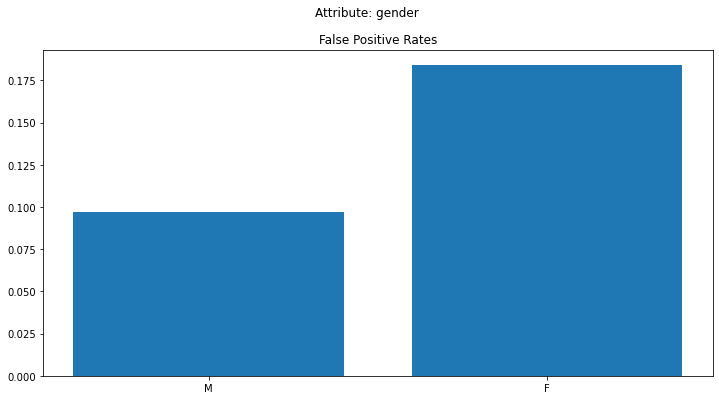

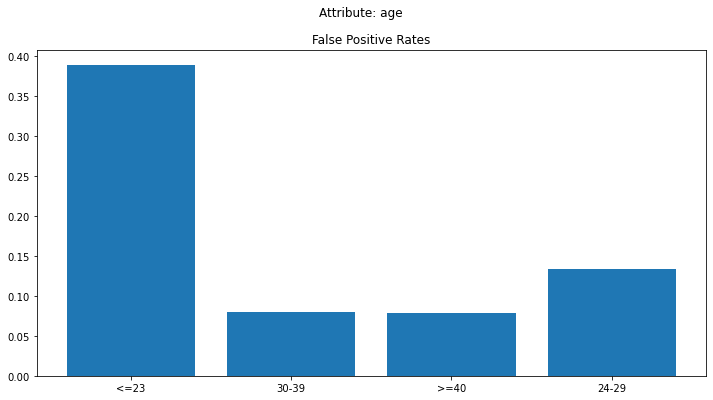

In [5]:
# SubgroupDifference Test
sgd_test = SubgroupDifference(
    #test_name='subgroup diff',
    #test_desc='my first subgroup difference test',
    attr='gender',
    metric='fpr',
    method='diff',
    threshold=0.2,
)
sgd_test.run(output)
sgd_test.plot()

sgd_test2 = SubgroupDifference(
    #test_name='subgroup diff',
    #test_desc='my first subgroup difference test',
    attr='age',
    metric='fpr',
    method='diff',
    threshold=0.2,
)
sgd_test2.run(output)
sgd_test2.plot()

In [6]:
# Permutation Test
# pmt = Permutation(
#     #test_name='permutation',
#     #test_desc='',
#     attr='age',
#     metric='pr',
#     method='ratio',
#     threshold=1.5,
# )

# pmt.run(
#     x_test=x_test,
#     y_test=y_test,
#     encoder=ens,
#     model=estimator
# )

True

Setting feature_perturbation = "tree_path_dependent" because no background data was given.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


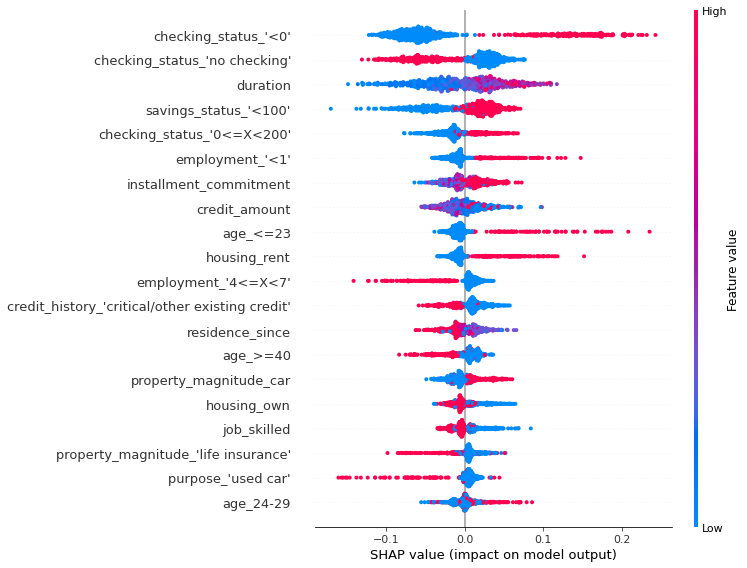

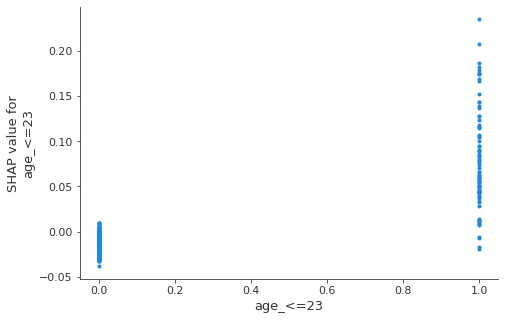

In [7]:
# shap_test = SHAPFeatureImportance(
#     #test_name='SHAP',
#     #test_desc='',
#     attrs=['gender','age'],
#     threshold=10
# )

# shap_test.run(
#     model=estimator,
#     model_type='trees',
#     x_train=x_train,
#     x_test=x_test,
# )
# shap_test.shap_summary_plot(x_test)
# shap_test.shap_dependence_plot(x_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


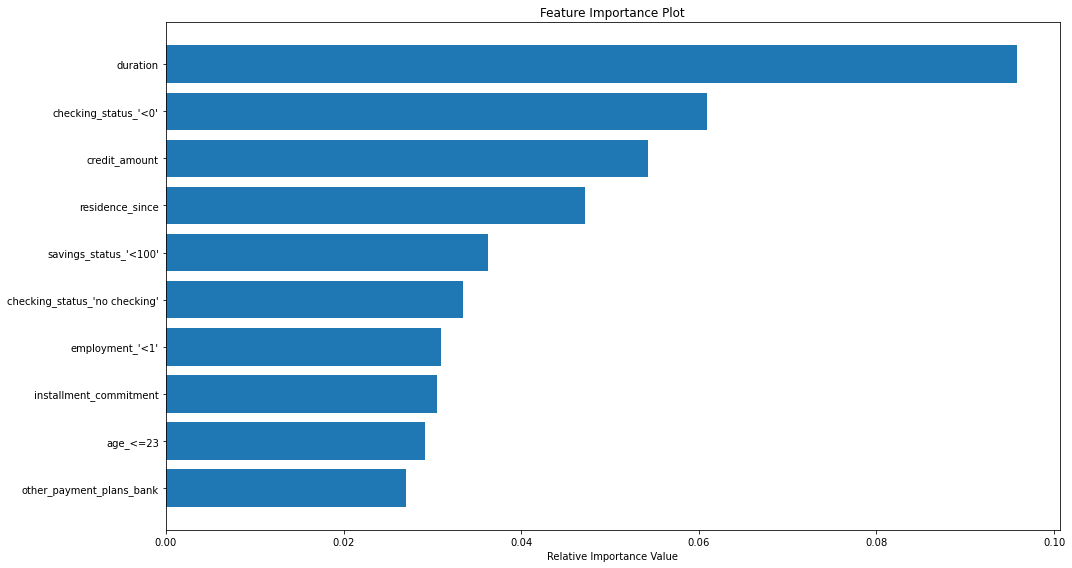

In [8]:
# imp_test = FeatureImportance(
#     #test_name='my feature importance FEAT test',
#     #test_desc='',
#     attrs=['gender','age'],
#     threshold=10
# )

# imp_test.run(df_importance)
# imp_test.plot(df_importance,show_n=10)

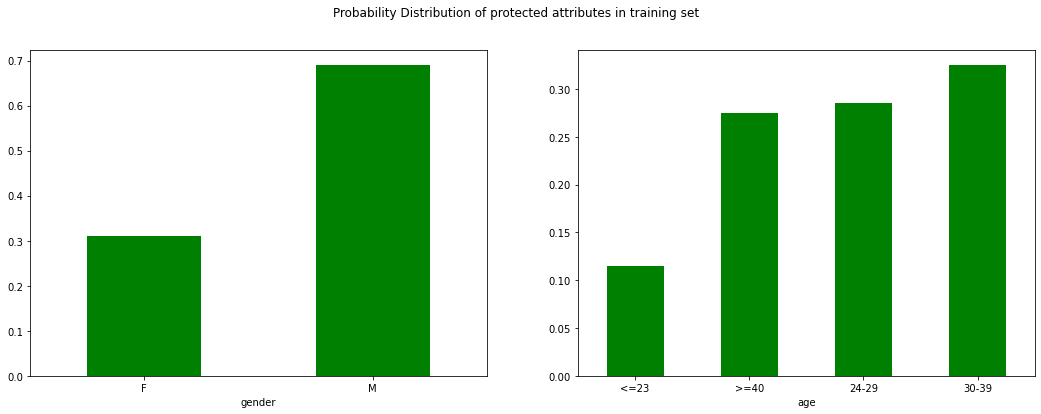

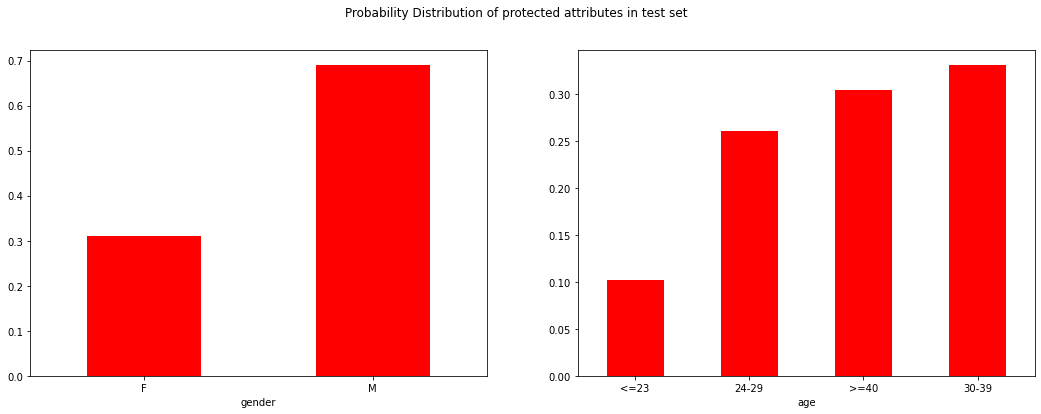

In [9]:
# shift_test = DataShift(
#     #test_name='my data shift FEAT test',
#     #test_desc='',
#     protected_attr = ['gender','age'],
#     method = 'ratio',
#     threshold = 1.25
# )

# shift_test.run(df_train = train, df_eval = test)
# shift_test.plot(train, test)


## Convert test objects to a model-card-compatible format

In [10]:
# init model card test objects
mc_smt_test = mctlib.Test()
mc_smt_test2 = mctlib.Test()
mc_sgd_test = mctlib.Test()
mc_sgd_test2 = mctlib.Test()
# mc_pmt_test = mctlib.Test()
# mc_shap_test = mctlib.Test()
# mc_imp_test = mctlib.Test()
# mc_shift_test = mctlib.Test()

# assign tests to them
mc_smt_test.read_model_test(smt_test)
mc_smt_test2.read_model_test(smt_test2)
mc_sgd_test.read_model_test(sgd_test)
mc_sgd_test2.read_model_test(sgd_test2)
# mc_pmt_test.read_model_test(pmt)
# mc_imp_test.read_model_test(imp_test)
# mc_shap_test.read_model_test(shap_test)
# mc_shift_test.read_model_test(shift_test)

In [11]:
# Convert form response to model card protobuf
pb = tally_form_to_mc("sample-form-response.json")

# Saving pb
with open('./temp.proto', "wb") as f:
    f.write(pb)
    
# Loading saved pb
# Alternative to load from file:
# with open('./temp.proto', "rb") as f:
#     model_card_proto.ParseFromString(f.read())

model_card_proto = model_card_pb2.ModelCard()    
model_card_proto.ParseFromString(pb);

# Copy to new model card
mc = mctlib.ModelCard()
mc.copy_from_proto(model_card_proto);

In [12]:
# Here's how the bootstrap model card looks like in html
# You can continue editing on this card by documenting other analysis and artifacts
mct = mctlib.ModelCardToolkit(output_dir = "model_card_output/")
mct.scaffold_assets()


mc.fairness_analysis.fairness_reports = [
    mctlib.FairnessReport(type='Model metrics of subgroups should be within a reasonable threshold', tests=[mc_smt_test,mc_smt_test2]),
    mctlib.FairnessReport(type='Model metrics across subgroups should be similar', tests=[mc_sgd_test,mc_sgd_test2]),
#     mctlib.FairnessReport(type='Model metric for subgroups in original data and perturbed data should be similar', tests=[mc_pmt_test]),
#     mctlib.FairnessReport(type="Protected Attributes should not be model's top important features", tests=[mc_imp_test,mc_shap_test]),
#     mctlib.FairnessReport(type="Distribution of subgroups should be silimiar across different datasets", tests=[mc_shift_test])
]

mct.update_model_card(mc)

html = mct.export_format(output_file="model_card_from_tally.html")

display.display(display.HTML(html))